# HW1 for MBML SF course, 1st semester.

Goal: to predict diabetes probability.

# Import библиотек.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler # Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder # Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder # Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline. Ни добавить, ни убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

# Набор данных

Набор данных представляет собой различные показатели здоровья людей и boolean значение диабета у них.

# Загружаем данные в pandas

Данные уже были предварительно очищены от дубликатов.

In [24]:
df = pd.read_csv("/home/synrocka/Study/diabetes_prediction/data/no_dup_diabetes_prediction_db", delimiter=',')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
96141,Female,36.0,0,0,No Info,24.60,4.8,145,0
96142,Female,2.0,0,0,No Info,17.37,6.5,100,0
96143,Male,66.0,0,0,former,27.83,5.7,155,0
96144,Female,24.0,0,0,never,35.42,4.0,100,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96146 entries, 0 to 96145
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  bool   
 3   heart_disease        96146 non-null  bool   
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  bool   
dtypes: bool(3), float64(3), int64(1), object(2)
memory usage: 4.7+ MB


# Работа с данными

Изменим тип колонок со значениями "0" и "1" на bool.

In [22]:
col_type_change_list = ['hypertension', 'heart_disease', 'diabetes']
for column in df.columns:
    if column in col_type_change_list:
        df[column] = df[column].astype(bool)

Посчитаем число категориальных и числовых колонок.

In [26]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes in [object, bool]):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))


categorical columns:	  ['gender', 'smoking_history'] 
 len =  2
numerical columns:	  ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'] 
 len =  7


# Предварительная обработка числовых признаков.

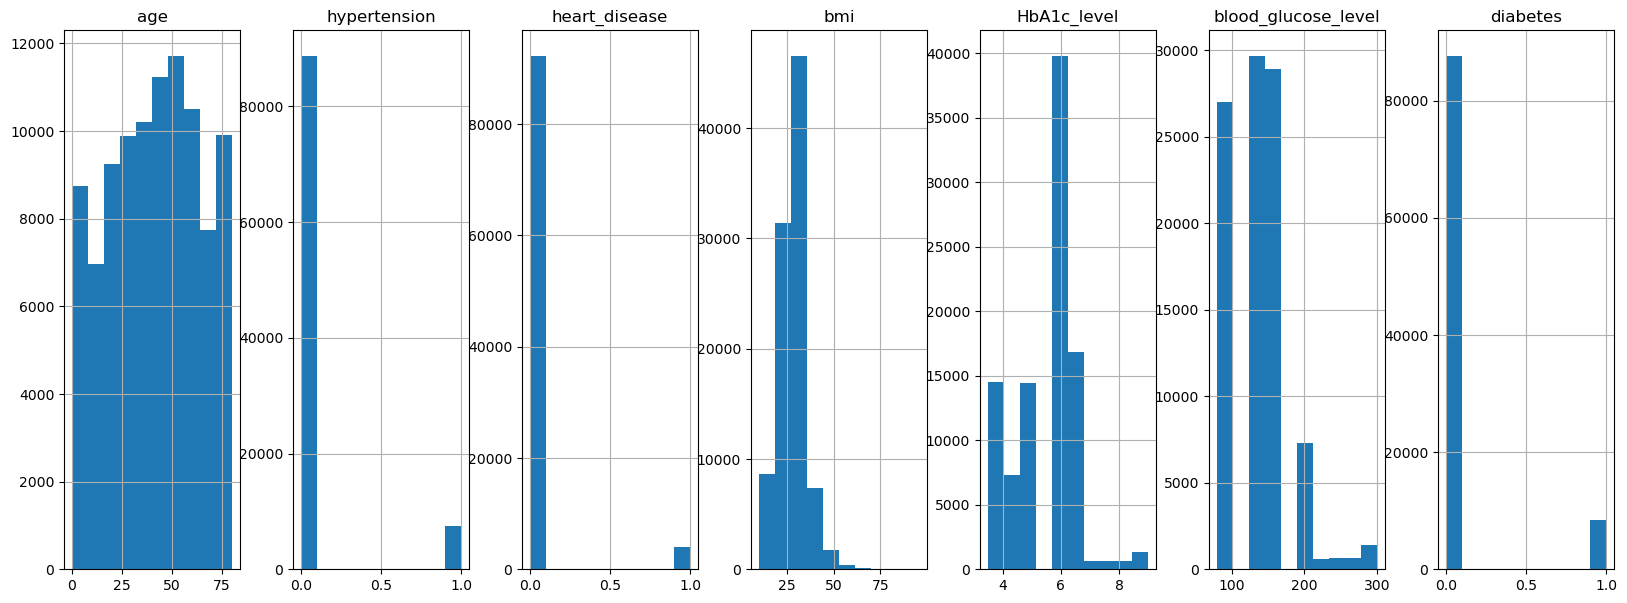

In [9]:
fig, axs = plt.subplots(1,7,figsize=(20,  7))

df.hist(column = num_columns, ax = axs );

# Стандартизация

## Первый шаг

In [12]:
scale = StandardScaler()

scale.fit(df[num_columns]);

In [13]:
scale.mean_, scale.scale_

(array([4.17943257e+01, 7.76007322e-02, 4.08025295e-02, 2.73214611e+01,
        5.53260874e+00, 1.38218231e+02, 8.82199988e-02]),
 array([22.46283076,  0.26754226,  0.19783246,  6.76768037,  1.07322644,
        40.90955861,  0.28361458]))

## Шаг второй

In [14]:
scaled = scale.transform(df[num_columns])
df_standard = pd.DataFrame(scaled, columns= num_columns)
df_standard

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1.700840,-0.290050,4.848534,-0.314947,0.994563,0.043554,-0.311056
1,0.543372,-0.290050,-0.206248,-0.000216,0.994563,-1.423096,-0.311056
2,-0.614096,-0.290050,-0.206248,-0.000216,0.155970,0.483549,-0.311056
3,-0.257952,-0.290050,-0.206248,-0.572051,-0.496269,0.410216,-0.311056
4,1.522768,3.447677,4.848534,-1.061141,-0.682623,0.410216,-0.311056
...,...,...,...,...,...,...,...
96141,-0.257952,-0.290050,-0.206248,-0.402126,-0.682623,0.165775,-0.311056
96142,-1.771563,-0.290050,-0.206248,-1.470439,0.901386,-0.934213,-0.311056
96143,1.077588,-0.290050,-0.206248,0.075142,0.155970,0.410216,-0.311056
96144,-0.792168,-0.290050,-0.206248,1.196649,-1.428039,-0.934213,-0.311056


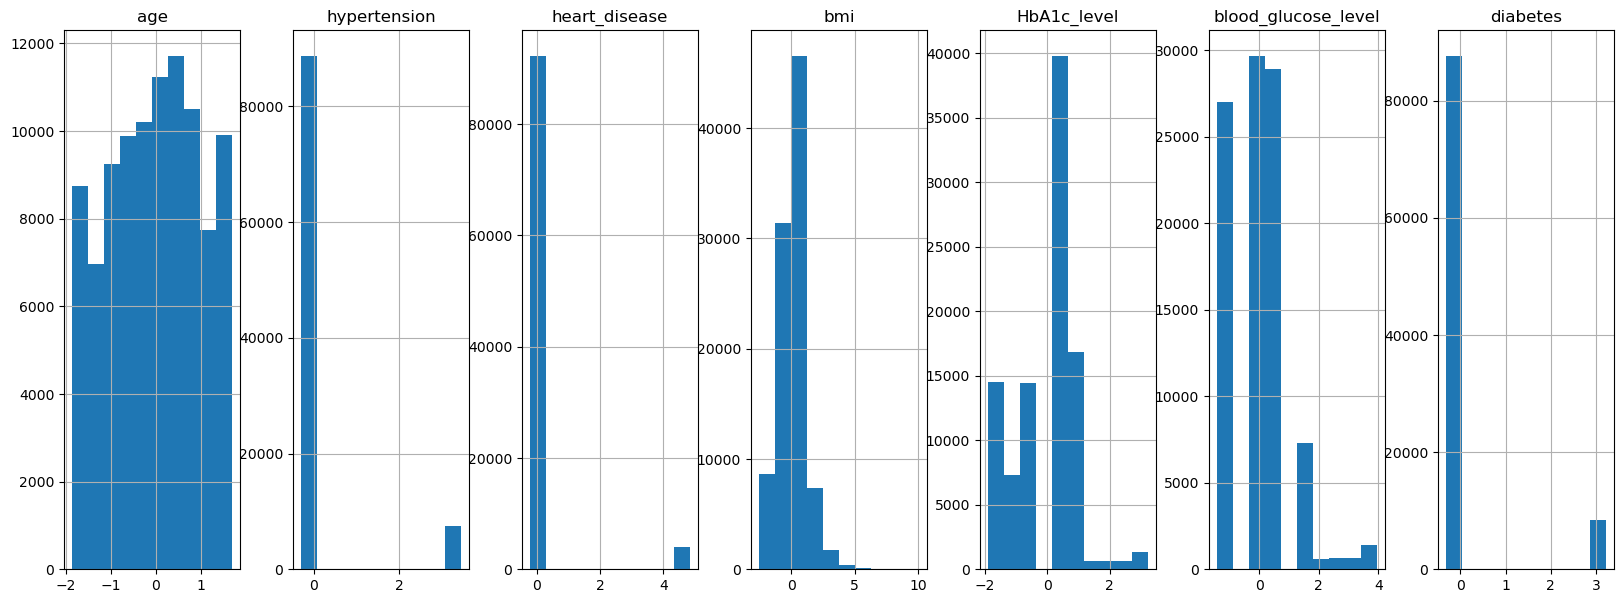

In [15]:
df_standard.hist(figsize = (20,7), layout= (1,7));

# Нормализация

## Первый шаг

In [17]:
norm = MinMaxScaler()

norm.fit(df[num_columns]);

In [18]:
norm.data_max_, norm.data_min_

(array([ 80.  ,   1.  ,   1.  ,  95.69,   9.  , 300.  ,   1.  ]),
 array([ 0.08,  0.  ,  0.  , 10.01,  3.5 , 80.  ,  0.  ]))